In [0]:
!pip install -q scipy==1.2.0
!pip install -q numpy
!pip install -q rawpy
!pip install -q Pillow

In [0]:
!python download_models.py

In [0]:
!python train_Sony_mine.py

In [0]:
!python test_Sony_50.py

In [0]:
!ls

In [0]:
!pwd

In [4]:
%cd /content/drive/My Drive/Bakalarka-Peter_Sipos/Implementation/Learning-to-See-in-the-Dark

/content/drive/My Drive/Bakalarka-Peter_Sipos/Implementation/Learning-to-See-in-the-Dark


In [0]:
a = []
while(1):
    a.append('1')

In [0]:
!pip install -q matplotlib

loaded ./results/result_Sony/model.ckpt
INFO:tensorflow:Restoring parameters from ./results/result_Sony/model.ckpt
Loading new photos to memory


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:193: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead


1 75 Loss=0.099 Time=0.251


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:301: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead


Epoch: 1   Validation_Loss=0.107 

1 

2 75 Loss=0.100 Time=0.246
Epoch: 2   Validation_Loss=0.085 

2 

3 75 Loss=0.084 Time=0.249
Epoch: 3   Validation_Loss=0.076 

3 

4 75 Loss=0.076 Time=0.232
Epoch: 4   Validation_Loss=0.076 

4 

5 75 Loss=0.073 Time=0.226
Epoch: 5   Validation_Loss=0.066 

5 

6 75 Loss=0.066 Time=0.224
Epoch: 6   Validation_Loss=0.069 

6 

7 75 Loss=0.065 Time=0.230
Epoch: 7   Validation_Loss=0.070 

7 

8 75 Loss=0.063 Time=0.244
Epoch: 8   Validation_Loss=0.065 

8 

9 75 Loss=0.059 Time=0.242
Epoch: 9   Validation_Loss=0.064 

9 

10 75 Loss=0.059 Time=0.237
Epoch: 10   Validation_Loss=0.062 

10 

11 75 Loss=0.059 Time=0.271
Epoch: 11   Validation_Loss=0.068 

11 

12 75 Loss=0.061 Time=0.246
Epoch: 12   Validation_Loss=0.059 

12 

13 75 Loss=0.061 Time=0.255
Epoch: 13   Validation_Loss=0.063 

13 

14 75 Loss=0.056 Time=0.237
Epoch: 14   Validation_Loss=0.061 

14 

15 75 Loss=0.059 Time=0.232
Epoch: 15   Validation_Loss=0.071 

15 

16 75 Loss=0.055 Ti

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


50 75 Loss=0.049 Time=0.389
Epoch: 50   Validation_Loss=0.062 

50 

51 75 Loss=0.048 Time=0.245
Epoch: 51   Validation_Loss=0.058 

51 

52 75 Loss=0.048 Time=0.256
Epoch: 52   Validation_Loss=0.064 

52 

53 75 Loss=0.049 Time=0.244
Epoch: 53   Validation_Loss=0.053 

53 

54 75 Loss=0.046 Time=0.222
Epoch: 54   Validation_Loss=0.050 

54 

55 75 Loss=0.046 Time=0.223
Epoch: 55   Validation_Loss=0.056 

55 

56 75 Loss=0.046 Time=0.251
Epoch: 56   Validation_Loss=0.058 

56 

57 75 Loss=0.049 Time=0.240
Epoch: 57   Validation_Loss=0.051 

57 

58 75 Loss=0.051 Time=0.274
Epoch: 58   Validation_Loss=0.061 

58 

59 75 Loss=0.047 Time=0.273
Epoch: 59   Validation_Loss=0.050 

59 

60 75 Loss=0.046 Time=0.245
Epoch: 60   Validation_Loss=0.052 

60 

61 75 Loss=0.048 Time=0.253
Epoch: 61   Validation_Loss=0.057 

61 

62 75 Loss=0.047 Time=0.252
Epoch: 62   Validation_Loss=0.054 

62 

63 75 Loss=0.048 Time=0.247
Epoch: 63   Validation_Loss=0.053 

63 

64 75 Loss=0.045 Time=0.237
Epoch:

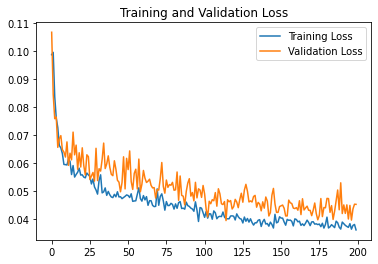

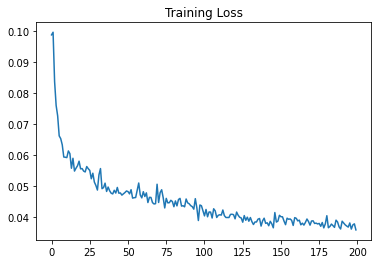

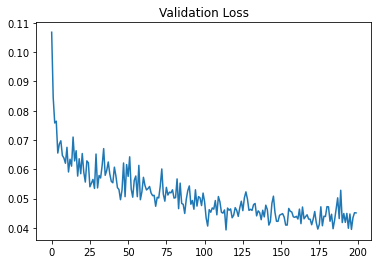

In [6]:
# uniform content loss + adaptive threshold + per_class_input + recursive G
# improvement upon cqf37
from __future__ import division
import os, time, scipy.io
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import rawpy
import glob
import random
import matplotlib.pyplot as plt
from scipy import misc

tf.reset_default_graph()

input_dir = './dataset/Sony/short/'
gt_dir = './dataset/Sony/long/'
checkpoint_dir = './results/result_Sony/'
result_dir = './results/result_Sony/'

# get train IDs
train_fns = glob.glob(gt_dir + '0*.ARW')
train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]

# get validation IDs
val_fns = glob.glob(gt_dir + '2*.ARW')
val_ids = [int(os.path.basename(val_fn)[0:5]) for val_fn in val_fns]

ps = 512  # patch size for training
save_freq = 50
selection_size = 75  # number of photos in selection
epochs_to_train = 200
amount_of_selections = 4  # number of different selections of images for training
epochs_for_selection = round(epochs_to_train/amount_of_selections)  # epoch to train on one selection

DEBUG = 0
if DEBUG == 1:
    save_freq = 2
    train_ids = train_ids[0:5]


def lrelu(x):
    return tf.maximum(x * 0.2, x)


def upsample_and_concat(x1, x2, output_channels, in_channels):
    pool_size = 2
    deconv_filter = tf.Variable(tf.truncated_normal([pool_size, pool_size, output_channels, in_channels], stddev=0.02))
    deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2), strides=[1, pool_size, pool_size, 1])

    deconv_output = tf.concat([deconv, x2], 3)
    deconv_output.set_shape([None, None, None, output_channels * 2])

    return deconv_output


def network(input):
    conv1 = slim.conv2d(input, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_1')
    conv1 = slim.conv2d(conv1, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_2')
    pool1 = slim.max_pool2d(conv1, [2, 2], padding='SAME')

    conv2 = slim.conv2d(pool1, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_1')
    conv2 = slim.conv2d(conv2, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_2')
    pool2 = slim.max_pool2d(conv2, [2, 2], padding='SAME')

    conv3 = slim.conv2d(pool2, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_1')
    conv3 = slim.conv2d(conv3, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_2')
    pool3 = slim.max_pool2d(conv3, [2, 2], padding='SAME')

    conv4 = slim.conv2d(pool3, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_1')
    conv4 = slim.conv2d(conv4, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_2')
    pool4 = slim.max_pool2d(conv4, [2, 2], padding='SAME')

    conv5 = slim.conv2d(pool4, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_1')
    conv5 = slim.conv2d(conv5, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_2')

    up6 = upsample_and_concat(conv5, conv4, 256, 512)
    conv6 = slim.conv2d(up6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_1')
    conv6 = slim.conv2d(conv6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_2')

    up7 = upsample_and_concat(conv6, conv3, 128, 256)
    conv7 = slim.conv2d(up7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_1')
    conv7 = slim.conv2d(conv7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_2')

    up8 = upsample_and_concat(conv7, conv2, 64, 128)
    conv8 = slim.conv2d(up8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_1')
    conv8 = slim.conv2d(conv8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_2')

    up9 = upsample_and_concat(conv8, conv1, 32, 64)
    conv9 = slim.conv2d(up9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_1')
    conv9 = slim.conv2d(conv9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_2')

    conv10 = slim.conv2d(conv9, 12, [1, 1], rate=1, activation_fn=None, scope='g_conv10')
    out = tf.depth_to_space(conv10, 2)
    return out


def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out


sess = tf.Session()
in_image = tf.placeholder(tf.float32, [None, None, None, 4])
gt_image = tf.placeholder(tf.float32, [None, None, None, 3])
out_image = network(in_image)

G_loss = tf.reduce_mean(tf.abs(out_image - gt_image))

t_vars = tf.trainable_variables()
lr = tf.placeholder(tf.float32)
G_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded ' + ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)


g_loss = np.zeros((5000, 1))
val_g_loss = np.zeros((5000, 1))        #TODO toto zrejme nemusi byt az 5000?
train_loss_list = []
val_loss_list = []

allfolders = glob.glob(result_dir + '*0')
lastepoch = 0
for folder in allfolders:
    lastepoch = np.maximum(lastepoch, int(folder[-4:]))

learning_rate = 1e-4

selection_ids = random.sample(train_ids, selection_size)
selection_fns = [None] * len(selection_ids)

first_run = True

# to keep validation images in memory
val_gt_images = [None] * 6000
val_input_images = {}
val_input_images['300'] = [None] * len(val_ids)
val_input_images['250'] = [None] * len(val_ids)
val_input_images['100'] = [None] * len(val_ids)

epochs_trained_real_counter = 0

# training
for epoch in range(lastepoch, epochs_to_train + 1):
    if os.path.isdir(result_dir + '%04d' % epoch):
        continue
    cnt = 0
    if epoch > epochs_to_train / 2:
        learning_rate = 1e-5

    # counter = 0

    # loading new selection
    if first_run or epoch % epochs_for_selection == 0:

        first_run = False

        selection_ids = random.sample(train_ids, selection_size)

        #debug vypisy
        # print("aktualna selection je:")
        # print(selection)
        # print("\n")

        gt_images = {}
        gt_images = [None] * 6000
        input_images = {}
        input_images['300'] = [None] * len(selection_ids)
        input_images['250'] = [None] * len(selection_ids)
        input_images['100'] = [None] * len(selection_ids)

        print("Loading new photos to memory")

        for ind in np.random.permutation(len(selection_ids)):
            # get the path from image id
            train_id = selection_ids[ind]
            in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
            in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
            in_fn = os.path.basename(in_path)

            gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
            gt_path = gt_files[0]
            gt_fn = os.path.basename(gt_path)
            in_exposure = float(in_fn[9:-5])
            gt_exposure = float(gt_fn[9:-5])
            ratio = min(gt_exposure / in_exposure, 300)

            if input_images[str(ratio)[0:3]][ind] is None:
                raw = rawpy.imread(in_path)
                input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

                gt_raw = rawpy.imread(gt_path)
                im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
                gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

                selection_fns[ind] = in_fn

                # debug vypisy
                # counter += 1
                # print("selection[ind] je: %d" % selection[ind])
                # print("train id je:  %d" % train_id)
                # print("ind je: %d" % ind)
                # print("ratio: %d" % ratio)
                # print("in_exposure: %d" % in_exposure)
                # print("inputed file:")
                # print(in_fn)
                # print("dal som fotku s id: %d do dict a je to v poradi fotka c: %d" % (train_id, counter))
                # print("input_images[str(ratio)[0:3]][ind] je")
                # print(input_images[str(ratio)[0:3]][ind])


    # trainin on every image from selection
    for ind in np.random.permutation(len(selection_fns)):
        # get the path from image id
        in_fn = selection_fns[ind]
        train_id = int(os.path.basename(in_fn)[0:5])

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)                  #TODO spravit funkciu 'get ratio'

        st = time.time()
        cnt += 1

        # debug vypisy
        # print("obrazok na spracovanie")
        # print("train id: %d" % train_id)
        # print("ind: %d" % ind)
        # print("in_exposure: %d" % in_exposure)
        # print("gt_exposure: %d" % gt_exposure)
        # print("ratio: %d" % ratio)
        # print("vsetky input images:")
        # print(in_files)
        # print(in_fn)
        # print("\n")


        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))

        input_patch = np.minimum(input_patch, 1.0)

        _, G_current, output = sess.run([G_opt, G_loss, out_image],
                                        feed_dict={in_image: input_patch, gt_image: gt_patch, lr: learning_rate})
        output = np.minimum(np.maximum(output, 0), 1)
        g_loss[ind] = G_current

        # print("%d %d Loss=%.3f Time=%.3f" % (epoch, cnt, np.mean(g_loss[np.where(g_loss)]), time.time() - st))


        if epoch % save_freq == 0:
            if not os.path.isdir(result_dir + '%04d' % epoch):
                os.makedirs(result_dir + '%04d' % epoch)

            temp = np.concatenate((gt_patch[0, :, :, :], output[0, :, :, :]), axis=1)
            scipy.misc.toimage(temp * 255, high=255, low=0, cmin=0, cmax=255).save(
                result_dir + '%04d/%05d_00_train_%d.jpg' % (epoch, train_id, ratio))

    print("%d %d Loss=%.3f Time=%.3f" % (epoch, cnt, np.mean(g_loss[np.where(g_loss)]), time.time() - st))

    # validate
    # print("\nRunning validation and calculating validation loss")

    for ind in np.random.permutation(len(val_ids)):
        val_id = val_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % val_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % val_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        if val_input_images[str(ratio)[0:3]][ind] is None:
            # print("Loading validation photo", in_fn, "to memory")

            raw = rawpy.imread(in_path)
            val_input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            val_gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        H = val_input_images[str(ratio)[0:3]][ind].shape[1]
        W = val_input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = val_input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = val_gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        input_patch = np.minimum(input_patch, 1.0)

        val_g_loss[ind] = sess.run(G_loss, feed_dict={in_image: input_patch, gt_image: gt_patch})

    print("Epoch: %d   Validation_Loss=%.3f \n" % (epoch, np.mean(val_g_loss[np.where(val_g_loss)])))

    saver.save(sess, checkpoint_dir + 'model.ckpt')

    epochs_trained_real_counter += 1
    train_loss_list.append(np.mean(g_loss[np.where(g_loss)]))
    val_loss_list.append(np.mean(val_g_loss[np.where(val_g_loss)]))

epochs_range = range(epochs_trained_real_counter)

plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.plot(train_loss_list)
plt.title('Training Loss')
plt.show()
plt.plot(val_loss_list)
plt.title('Validation Loss')
plt.show()